In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

import copy
import random
import time

In [2]:
SEED = 12

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Build model

In [3]:
class Lenet5(nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.avg_pooling = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0))
        self.linear1 = nn.Linear(120,84)
        self.linear2 = nn.Linear(84,10)

    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.avg_pooling(x)
        x = self.relu(self.conv2(x))
        x = self.avg_pooling(x)
        x = self.relu(self.conv3(x))
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [4]:
model = Lenet5()

# Data processing

In [5]:
pretrained_size = (28,28,1)

# Kích thước mục tiêu là 32x32
pretrained_size = (32, 32)

train_trans = transforms.Compose([
    transforms.Resize(pretrained_size),             # Thay đổi kích thước ảnh
    transforms.Grayscale(num_output_channels=1),    # Chuyển đổi thành ảnh grayscale (1 kênh)
    transforms.RandomRotation(5),                   # Xoay ngẫu nhiên ảnh
    transforms.RandomHorizontalFlip(0.5),           # Lật ngang ngẫu nhiên
    transforms.RandomCrop(pretrained_size, padding=10),  # Cắt ngẫu nhiên sau khi padding
    transforms.ToTensor(),                          # Chuyển đổi thành tensor
])


test_trans = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

In [6]:
train_folder_direc = "E:/Data/Dog_cat/training_set"
test_folder_direc = "E:/Data/Dog_cat/test_set"

# Tải các tập dữ liệu với ImageFolder
train_data = datasets.ImageFolder(root=train_folder_direc, transform=train_trans,)
test_data = datasets.ImageFolder(root=test_folder_direc, transform=test_trans)

In [7]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [8]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_trans

In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 7204
Number of validation examples: 801
Number of testing examples: 2023


In [10]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

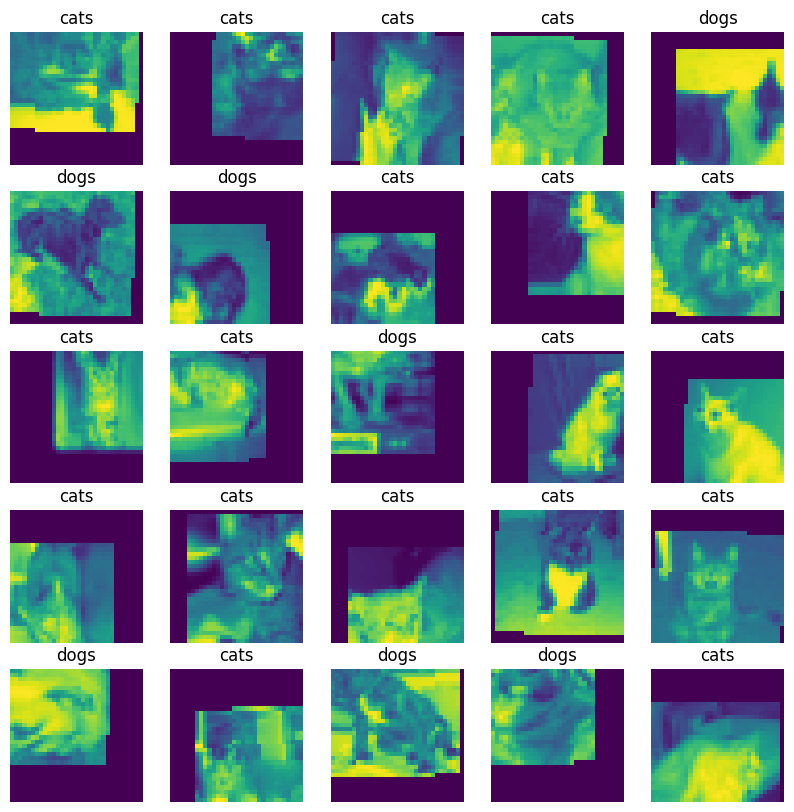

In [11]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [12]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

# Training model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 61,706 trainable parameters


In [16]:
FOUND_LR = 5e-4

params = [
          {'params': model.parameters(), 'lr': FOUND_LR },
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

In [17]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion, device):

    # Khỏi tạo loss và accuracy
    epoch_loss = 0
    epoch_acc = 0

    # Đặt model ở chế độ huấn luyện
    model.train()

    for(x,y) in tqdm(iterator, desc="Training", leave=True):

        x = x.to(device)
        y = y.to(device)

        # Đặt lại gradient bằng 0
        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        # Truyền ngược để tính gradient
        loss.backward()

        # Cập nhật tham số mô hình
        optimizer.step()

        # Cộng dồn loss và acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # Tính toán loss và acc trung bình
    avg_loss = epoch_loss/len(iterator)
    avg_acc = epoch_acc/len(iterator)

    return avg_loss, avg_acc

In [19]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    avg_loss = epoch_loss / len(iterator)
    avg_acc = epoch_acc / len(iterator)

    return avg_loss, avg_acc


In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
EPOCHS = 15

# Danh sách để lưu trữ giá trị accuracy
train_accuracies = []
valid_accuracies = []

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'dog_cat_model_lenet5.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 0.682 | Train Acc: 56.19%
	 Val. Loss: 0.678 |  Val. Acc: 57.31%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 0.686 | Train Acc: 55.04%
	 Val. Loss: 0.678 |  Val. Acc: 56.60%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.685 | Train Acc: 55.52%
	 Val. Loss: 0.675 |  Val. Acc: 58.76%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.681 | Train Acc: 56.31%
	 Val. Loss: 0.692 |  Val. Acc: 54.79%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 0.681 | Train Acc: 55.96%
	 Val. Loss: 0.676 |  Val. Acc: 57.32%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.686 | Train Acc: 54.67%
	 Val. Loss: 0.673 |  Val. Acc: 59.60%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.680 | Train Acc: 56.23%
	 Val. Loss: 0.677 |  Val. Acc: 57.20%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 0.681 | Train Acc: 56.07%
	 Val. Loss: 0.672 |  Val. Acc: 58.76%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 13s
	Train Loss: 0.680 | Train Acc: 56.37%
	 Val. Loss: 0.672 |  Val. Acc: 59.24%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 13s
	Train Loss: 0.679 | Train Acc: 56.87%
	 Val. Loss: 0.671 |  Val. Acc: 59.60%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 13s
	Train Loss: 0.681 | Train Acc: 56.06%
	 Val. Loss: 0.671 |  Val. Acc: 58.98%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 13s
	Train Loss: 0.681 | Train Acc: 56.21%
	 Val. Loss: 0.668 |  Val. Acc: 59.95%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 14s
	Train Loss: 0.680 | Train Acc: 56.71%
	 Val. Loss: 0.668 |  Val. Acc: 59.94%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 14s
	Train Loss: 0.678 | Train Acc: 57.17%
	 Val. Loss: 0.665 |  Val. Acc: 61.15%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 14s
	Train Loss: 0.675 | Train Acc: 57.58%
	 Val. Loss: 0.663 |  Val. Acc: 62.57%


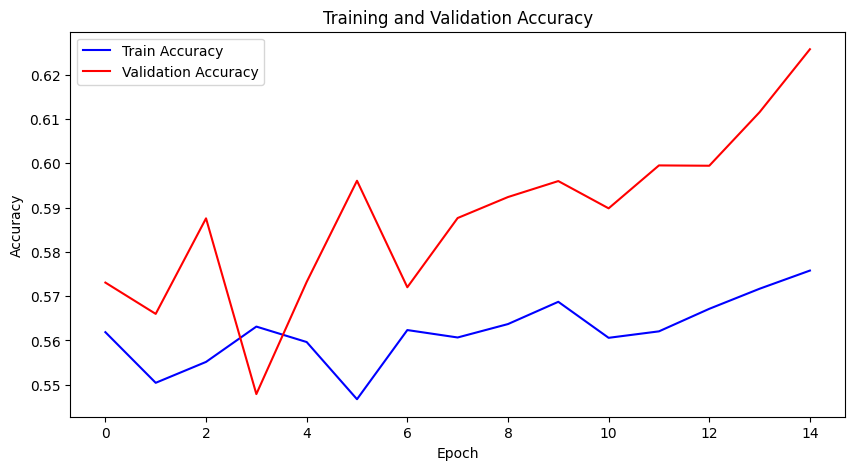

In [39]:
# Vẽ đồ thị
plt.figure(figsize=(10, 5))

# Đồ thị accuracy của train
plt.plot(train_accuracies, label='Train Accuracy', color='blue')

# Đồ thị accuracy của validation
plt.plot(valid_accuracies, label='Validation Accuracy', color='red')

# Thêm tiêu đề và nhãn trục
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Hiển thị chú thích
plt.legend()

# Hiển thị đồ thị
plt.show()


In [22]:
model.load_state_dict(torch.load('dog_cat_model_lenet5.pt'))

<All keys matched successfully>

In [23]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 0.675 | Test Acc: 57.82%


# Examining the Model

In [24]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [25]:
images, labels, probs = get_predictions(model, test_iterator)

  0%|          | 0/32 [00:00<?, ?it/s]

In [26]:
pred_labels = torch.argmax(probs, 1)

In [27]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

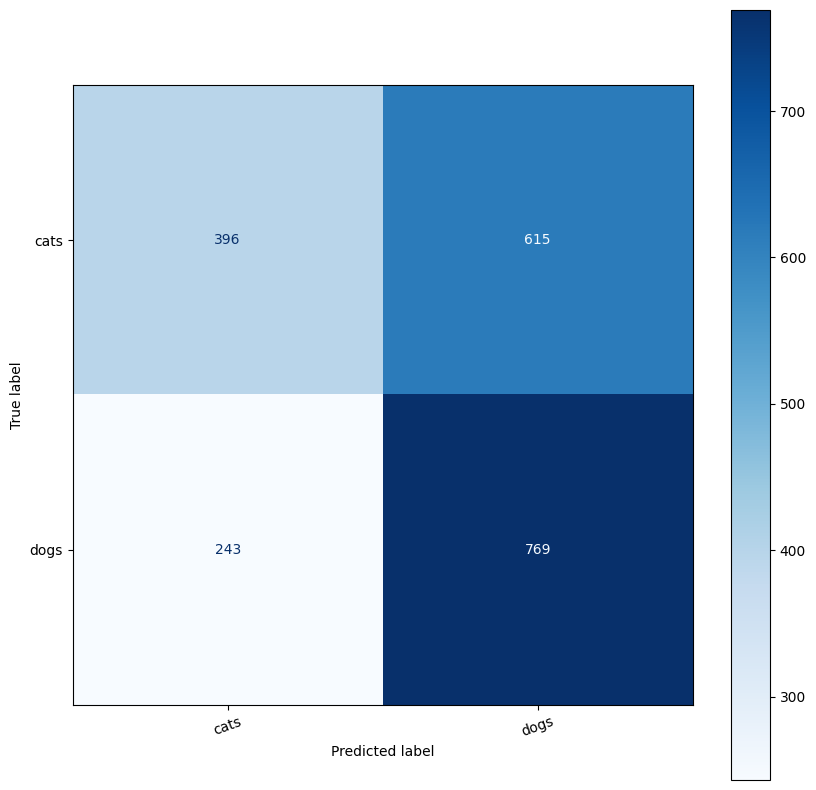

In [28]:
plot_confusion_matrix(labels, pred_labels, classes)

In [29]:
corrects = torch.eq(labels, pred_labels)

In [30]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [31]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

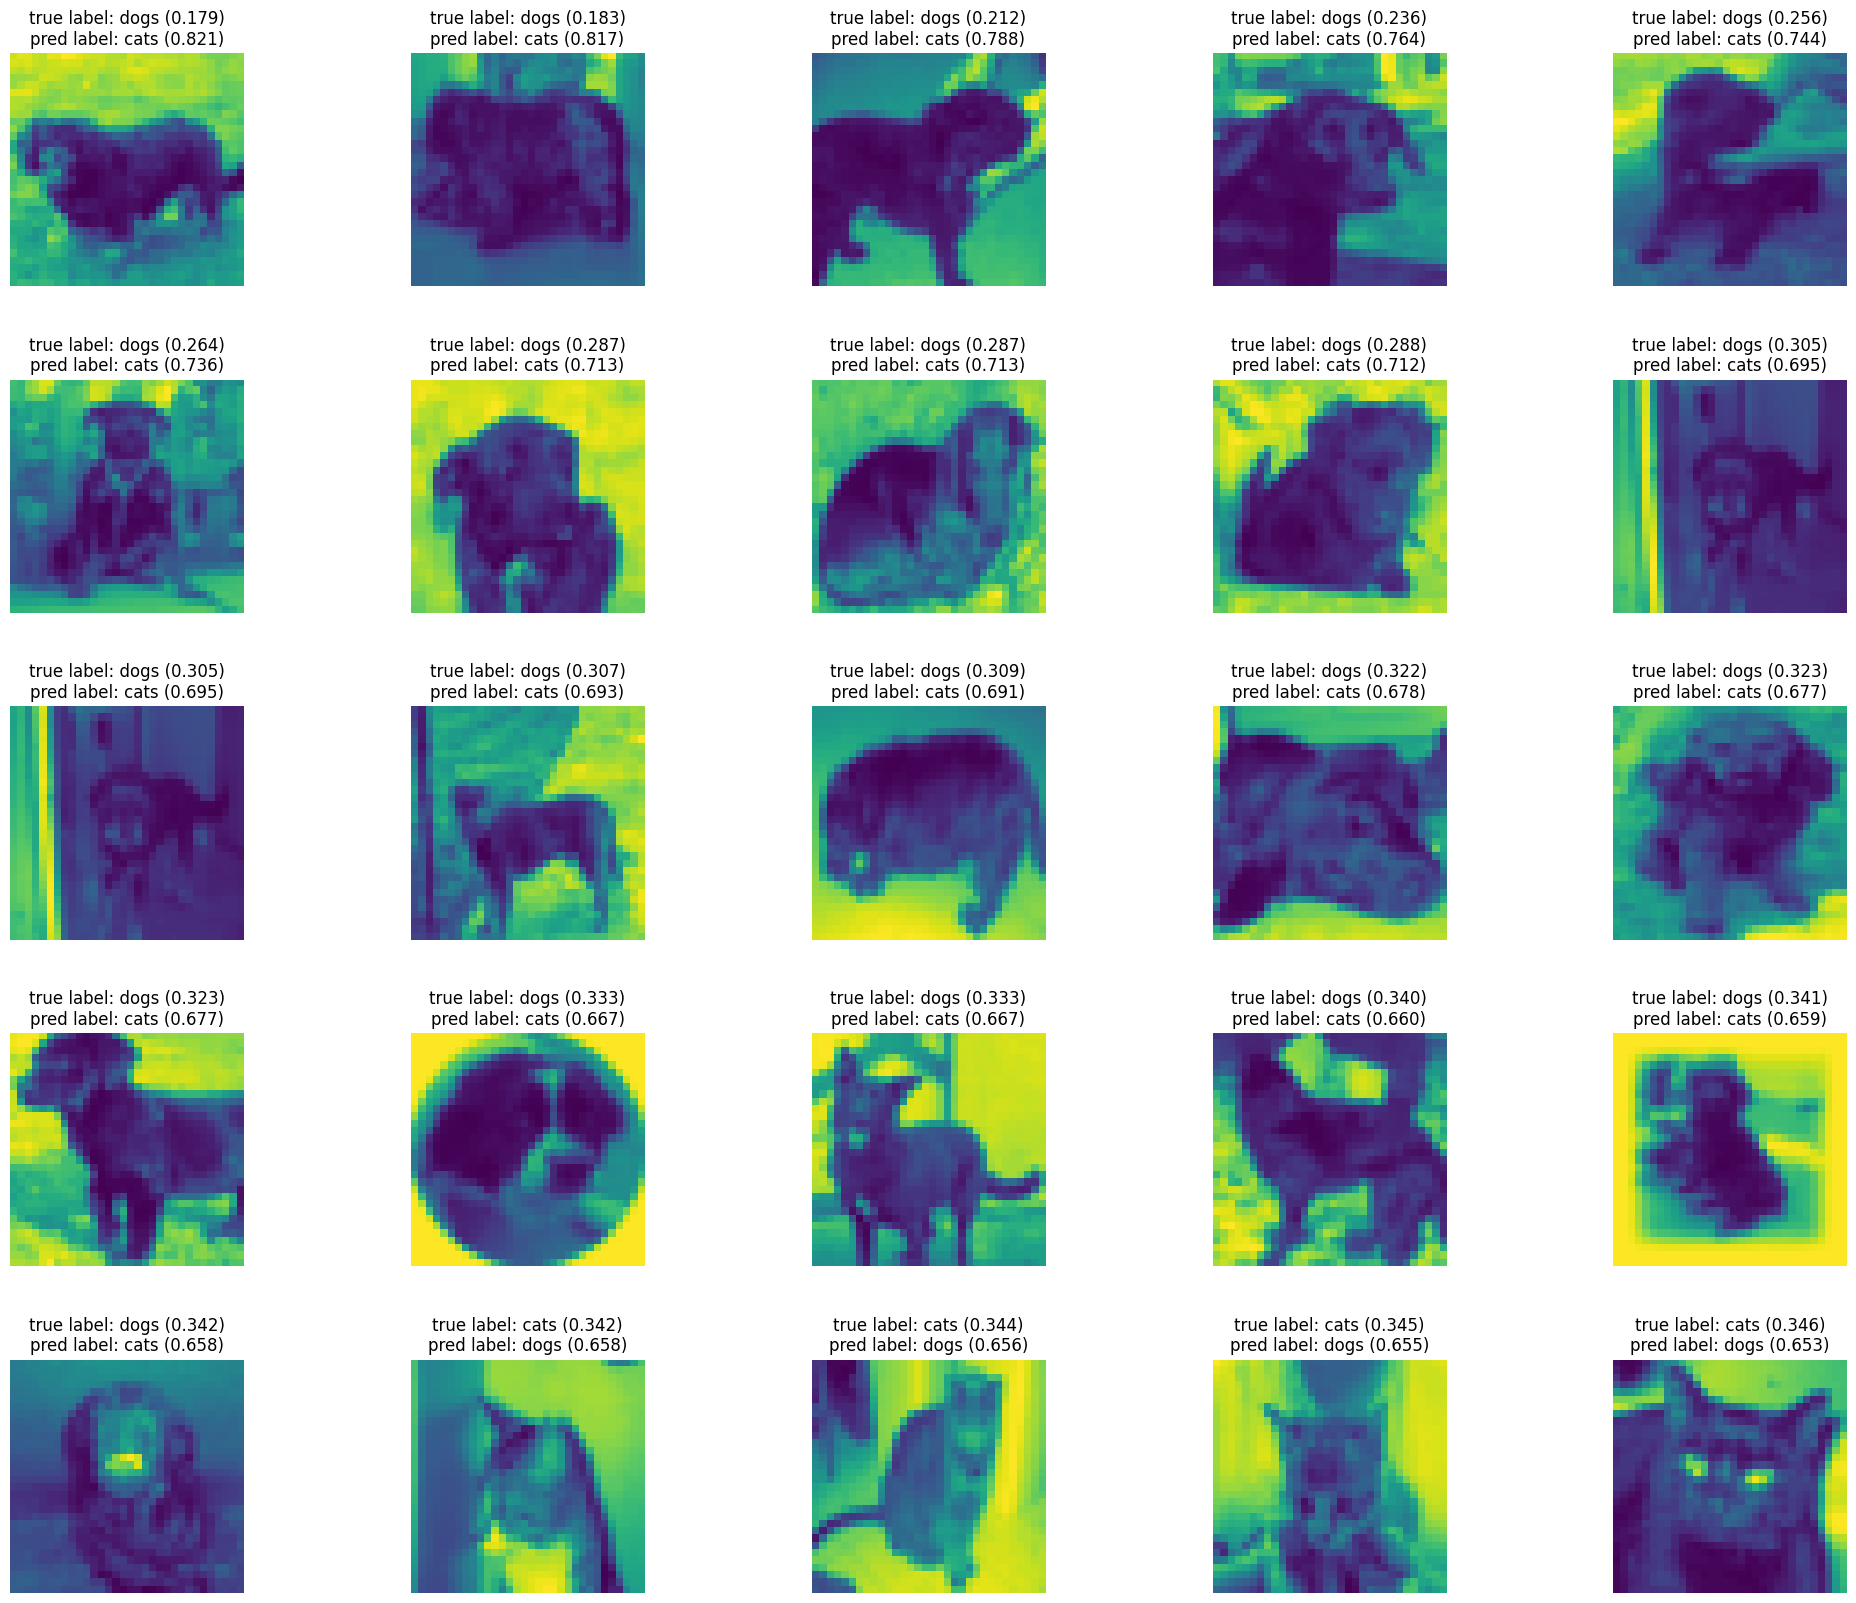

In [32]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [33]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, labels

In [34]:
outputs, labels = get_representations(model, train_iterator)

  0%|          | 0/113 [00:00<?, ?it/s]

In [35]:
def plot_representations(data, labels, classes, n_images=None):

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

In [36]:
def get_tsne(data, n_components=2, n_images=None):

    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

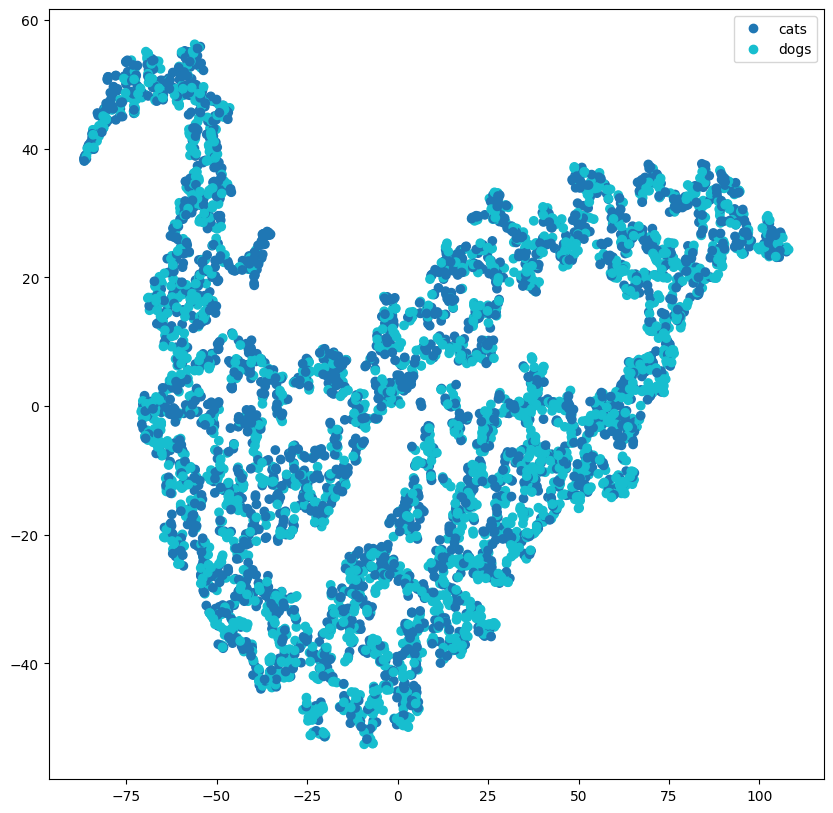

In [37]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images=N_IMAGES)